In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
embed_file = os.path.join('.', 'Glove', 'glove.6B.300d.txt')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [3]:
embed_size = 300 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [4]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(-0.0039050116, 0.38177028)

In [8]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [9]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9, random_state=6)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
cp = ModelCheckpoint(filepath="my_model2.h5", save_best_only=True)
es = EarlyStopping(patience=2)
rp = ReduceLROnPlateau(patience = 1)
hist = model.fit(X_tra, y_tra, batch_size = 128, epochs=5, validation_data=(X_val, y_val), callbacks=[cp, es, rp, RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 3250s 23ms/step - loss: 0.0610 - acc: 0.9792 - val_loss: 0.0454 - val_acc: 0.9830

 ROC-AUC - epoch: 1 - score: 0.983483 

Epoch 2/5
143613/143613 [==============================] - 3268s 23ms/step - loss: 0.0420 - acc: 0.9839 - val_loss: 0.0442 - val_acc: 0.9832

 ROC-AUC - epoch: 2 - score: 0.984744 

Epoch 3/5
143613/143613 [==============================] - 3478s 24ms/step - loss: 0.0367 - acc: 0.9857 - val_loss: 0.0445 - val_acc: 0.9832

 ROC-AUC - epoch: 3 - score: 0.984333 

Epoch 4/5
143613/143613 [==============================] - 3517s 24ms/step - loss: 0.0321 - acc: 0.9872 - val_loss: 0.0484 - val_acc: 0.9833

 ROC-AUC - epoch: 4 - score: 0.982817 



{'val_loss': [0.04542083532969289, 0.0441904425924976, 0.04449956982100887, 0.04839420795318349], 'val_acc': [0.9829865969546622, 0.9831745942548218, 0.9832059212429569, 0.9832685859015986], 'loss': [0.060957373864381964, 0.04200235710395086, 0.03672169635733906, 0.032110245758809934], 'acc': [0.9792022154341218, 0.983884936949095, 0.9856582230562639, 0.98722377022178], 'lr': [0.001, 0.001, 0.001, 0.001]}


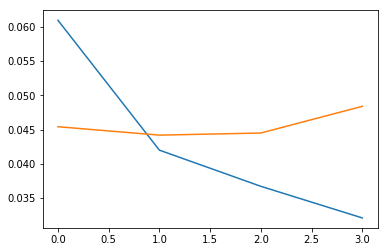

In [12]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [13]:
y_pred = model.predict(X_te, batch_size=512)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission2.csv', index=False)